# EXAMPLE 2:
In this example we show how one can perturb the initial condition of the KdV equation.
This is done to investigate initial condition sensitivity. And demonstrate that one can instanciate two instances of the class for comparison. 

In [2]:
import jax
import jax.numpy as jnp
import numpy as np
import matplotlib.pyplot as plt
from ipywidgets import interact
from ml_collections import ConfigDict
from models.ETD_KT_CM_JAX_Vectorised import *
from filters import resamplers
from filters.filter import ParticleFilter
from jax import config
config.update("jax_enable_x64", True)

True


In [3]:
signal_params = ConfigDict(KDV_params_2)
signal_params.update(tmax=4,initial_condition='gaussian')

signal_model = ETD_KT_CM_JAX_Vectorised(signal_params)
signal_model_2 = ETD_KT_CM_JAX_Vectorised(signal_params)
print(signal_model.params)


Advection_basis_name: none
E: 1
Forcing_basis_name: none
P: 1
S: 0
c_0: 0
c_1: 1
c_2: 0.0
c_3: 2.0e-05
c_4: 0.0
dt: 0.001
equation_name: KdV
initial_condition: gaussian
method: Dealiased_SETDRK4
noise_magnitude: 0.0
nt: 4000
nx: 256
tmax: 4
xmax: 1
xmin: 0



Now we continue to define a stochastic ensemble

Now we specify the models, by calling the class.

In [4]:
initial_signal = initial_condition(signal_model.x, signal_params.E, signal_params.initial_condition)
initial_signal_2 = initial_signal + 1e-8*jnp.asarray(np.random.randn(*initial_signal.shape))
time = jnp.linspace(0, signal_model.params.tmax, signal_model.params.nt)

In [5]:
final, all = signal_model.run(initial_signal, signal_model.params.nt,None) 
final_2, all_2 = signal_model_2.run(initial_signal_2, signal_model_2.params.nt,None)  

Put in the initial condition.

In [6]:

signal = jnp.concatenate([initial_signal[None,...], all], axis=0)
signal_2 = jnp.concatenate([initial_signal_2[None,...], all_2], axis=0)


In [7]:
def plot(da_step):
    plt.plot(signal_model.x, signal[da_step,0,:], color='k',label='signal')
    plt.plot(signal_model.x, signal_2[da_step,0,:], color='r',label='signal_perturbed')
    plt.legend()
    plt.show()

interact(plot, da_step=(0, signal_model.params.nt))

interactive(children=(IntSlider(value=2000, description='da_step', max=4000), Output()), _dom_classes=('widget…

<function __main__.plot(da_step)>

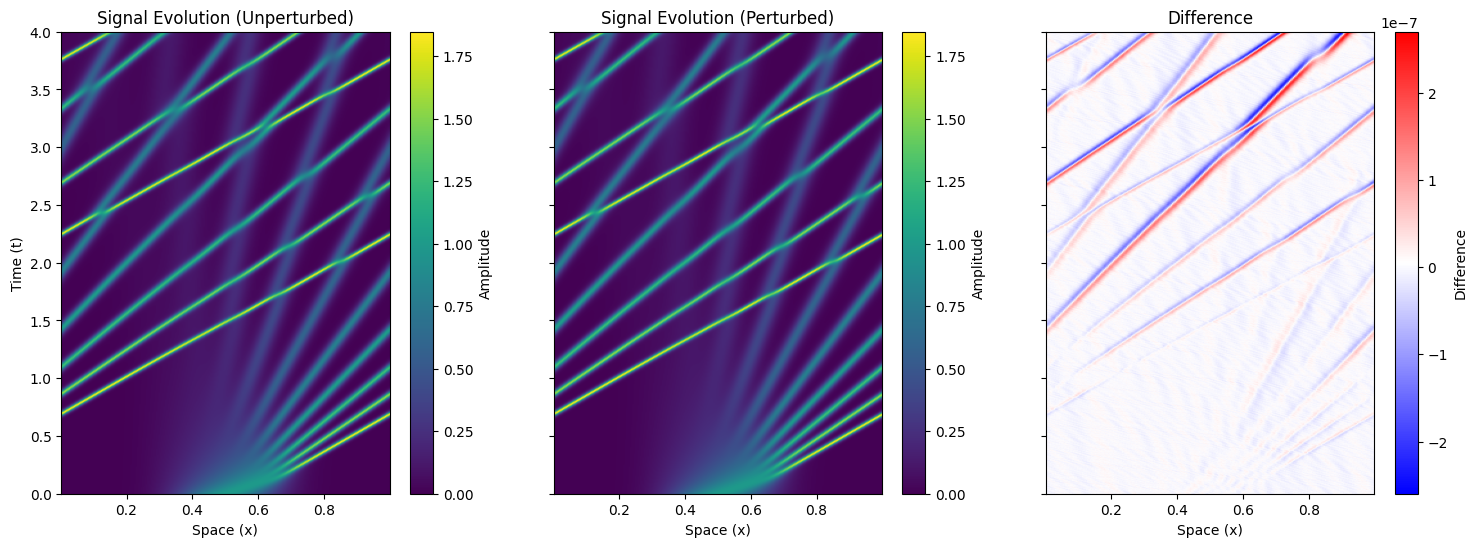

In [8]:

# Side by side plots with difference
fig, axs = plt.subplots(1, 3, figsize=(18, 6), sharey=True)

im_a = axs[0].imshow(all[:,0,:], aspect='auto', origin='lower', extent=[signal_model.x[0], signal_model.x[-1], time[0], time[-1]])
axs[0].set_title('Signal Evolution (Unperturbed)')
axs[0].set_xlabel('Space (x)')
axs[0].set_ylabel('Time (t)')
plt.colorbar(im_a, ax=axs[0], label='Amplitude')

im_b = axs[1].imshow(all_2[:,0,:], aspect='auto', origin='lower', extent=[signal_model.x[0], signal_model.x[-1], time[0], time[-1]])
axs[1].set_title('Signal Evolution (Perturbed)')
axs[1].set_xlabel('Space (x)')
plt.colorbar(im_b, ax=axs[1], label='Amplitude')

diff = all[:,0,:] - all_2[:,0,:]
im_c = axs[2].imshow(diff, aspect='auto', origin='lower', extent=[signal_model.x[0], signal_model.x[-1], time[0], time[-1]], cmap='bwr')
axs[2].set_title('Difference')
axs[2].set_xlabel('Space (x)')
plt.colorbar(im_c, ax=axs[2], label='Difference')
plt.savefig('/Users/jmw/Documents/GitHub/Particle_Filter/Saving/KdV_sensitivity.png',bbox_inches='tight',dpi=300)


In [9]:
plt.figure(dpi=300, figsize=(8, 5))
plt.plot(time, relative_error, c='k', label=r'$\frac{||u_1 - u_2||_{2}}{||u_2||_{2}}$')
plt.yscale('log')
plt.xscale('log')
plt.xlabel('Time', fontsize=14)
plt.ylabel(r'Relative $L^2$ Error', fontsize=14)
plt.title(r'KdV Relative $L^2$ Error', fontsize=16)
plt.grid(True, which='both', ls='--', alpha=0.5)
mask = relative_error > 3.5e-8
plt.loglog(time[mask], time[mask] * relative_error[-1] / time[-1], '--', label=r'$\mathcal{O}(\Delta t)$', c='k')
plt.legend(fontsize=12)
plt.tight_layout()
plt.savefig('/Users/jmw/Documents/GitHub/Particle_Filter/Saving/KdV_ic_pertubation_error.png',bbox_inches='tight',dpi=300)

plt.show()

NameError: name 'relative_error' is not defined

<Figure size 2400x1500 with 0 Axes>

We see that the initial condition pertubation grows linearly in time.